In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:

    def __init__(self,data, _children = (), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data ={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data , (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
   
    def exp(self):
        n = self.data
        out = Value(math.exp(n), (self, ), 'exp' )

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
         
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        
        build_topo(self)
        self.grad = 1
        for node in reversed (topo):
            node._backward()


In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label , n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot
    


In [7]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range (nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [31]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 

In [32]:
for k in range (40):
    
    # forward Pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0))

    #Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #Update
    for p in n.parameters():
        p.data -= 0.05*p.grad

    print (k, loss.data)
    

0 0.030828800171201775
1 0.029937752371936716
2 0.029094566864319965
3 0.028295550399935546
4 0.027537376912180597
5 0.026817043236672257
6 0.02613183106501675
7 0.025479274134391196
8 0.024857129833393492
9 0.024263354547721543
10 0.023696082184881125
11 0.023153605411020205
12 0.022634359209589595
13 0.022136906434298595
14 0.021659925080488963
15 0.021202197041732138
16 0.02076259815385946
17 0.020340089358116153
18 0.019933708839764003
19 0.019542565019115866
20 0.019165830289366564
21 0.018802735410253672
22 0.018452564479004695
23 0.01811465041057291
24 0.017788370868149522
25 0.017473144592610474
26 0.017168428086126102
27 0.016873712610802415
28 0.01658852146807712
29 0.01631240752878151
30 0.016044950987402752
31 0.015785757317219415
32 0.015534455405711543
33 0.015290695852020749
34 0.015054149410306975
35 0.014824505564659606
36 0.014601471222805838
37 0.014384769517251709
38 0.014174138703713618
39 0.013969331147776202


In [33]:
ypred

[Value(data =0.950336899671886),
 Value(data =-0.9308278719849826),
 Value(data =-0.9565027404347969),
 Value(data =0.9305297709103585)]

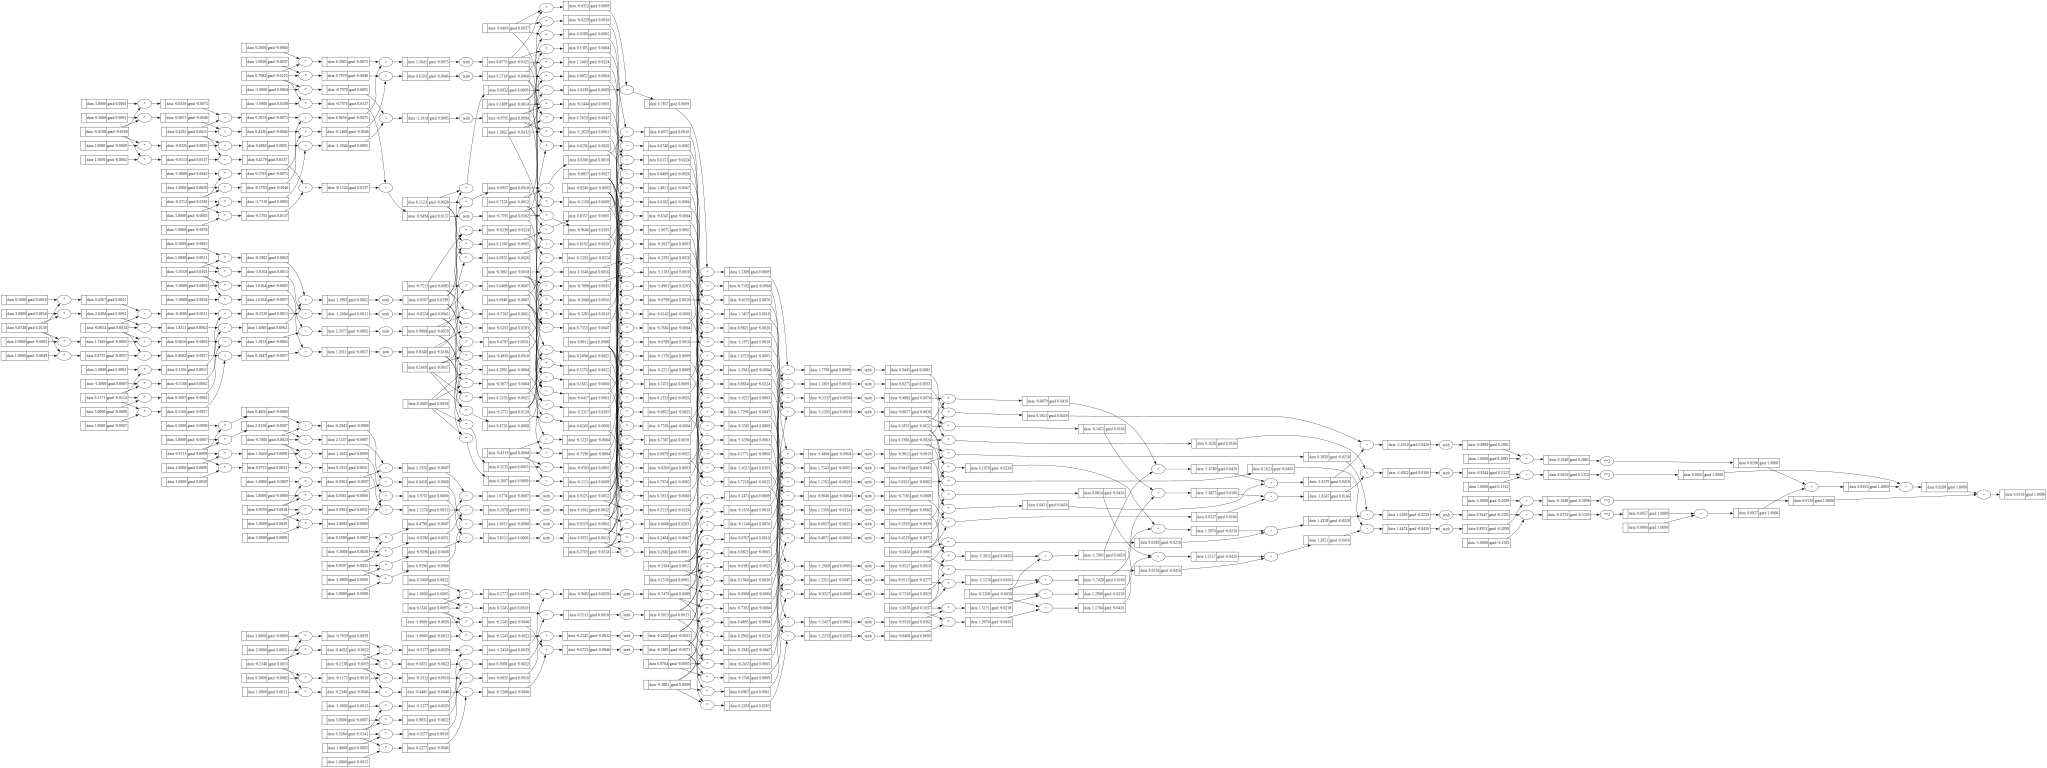

In [30]:
draw_dot(loss)